# Natural Language Processing with Disaster Tweets

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score

### Загрузим данные

In [2]:
data = pd.read_csv('data/train.csv')
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


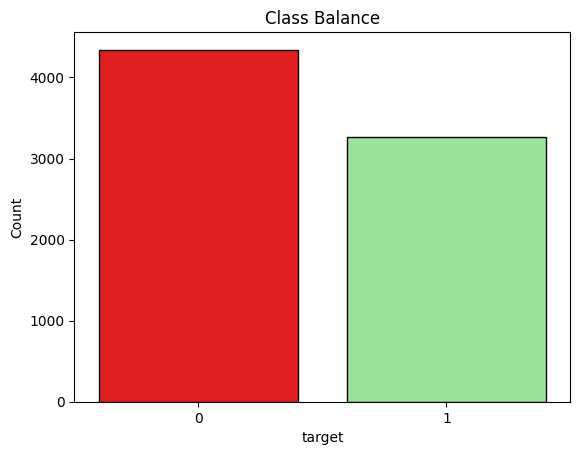

In [3]:
sns.countplot(x='target', data=data, palette=['red', 'lightgreen'], hue='target', legend=False, edgecolor='black')
plt.title('Class Balance')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

In [4]:
data['text'].duplicated().sum()

np.int64(110)

In [5]:
data[data['text'].duplicated() == True]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [6]:
data['tweet_len'] = data['text'].str.len()

In [7]:
data['tweet_len'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: tweet_len, dtype: float64

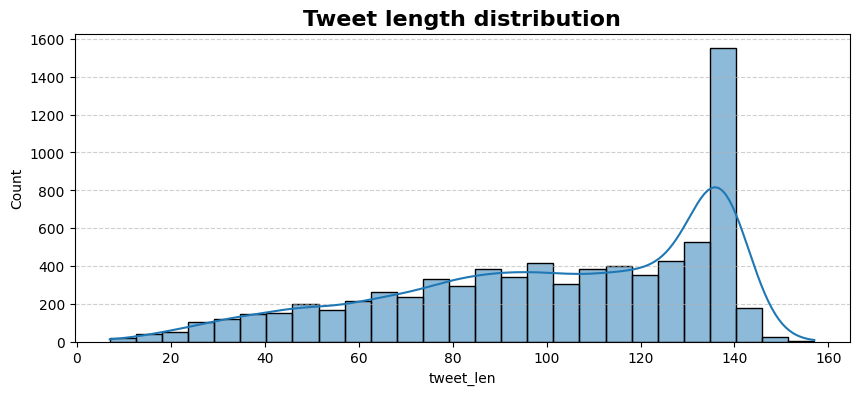

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(data['tweet_len'], kde=True)
plt.title('Tweet length distribution', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.6, linestyle='--')
plt.show()

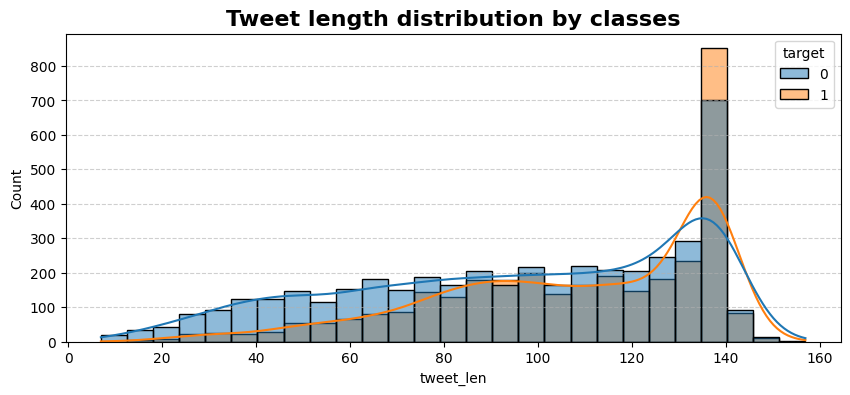

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(data, x='tweet_len', hue='target', kde=True, alpha=0.5)
plt.title('Tweet length distribution by classes', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.6, linestyle='--')
plt.show()

### Посмотрим на самы часто встречающиеся токены
Будем токенизировать по словам

In [10]:
tokens = []

for tweet in data['text']:
    tokens.extend(tweet.lower().strip().split())

freq_dist = FreqDist(tokens)

In [11]:
print(f'Размер словаря: {len(freq_dist)}')

Размер словаря: 27983


Посмотрим на топ 20

In [12]:
print(freq_dist.most_common(20))

[('the', 3207), ('a', 2135), ('in', 1949), ('to', 1934), ('of', 1814), ('and', 1405), ('i', 1336), ('is', 930), ('for', 880), ('on', 834), ('-', 763), ('you', 746), ('my', 671), ('with', 562), ('that', 538), ('at', 532), ('by', 514), ('it', 504), ('this', 463), ('from', 420)]


In [13]:
stop_words = stopwords.words('english') # удалим стопслова
keys_to_delete = [key for key in freq_dist.keys() if key in stop_words]

for key in keys_to_delete:
    del freq_dist[key]

In [14]:
print(freq_dist.most_common(20))

[('-', 763), ('like', 341), ('&amp;', 295), ('get', 227), ('new', 215), ('??', 214), ('via', 214), ('fire', 209), ('one', 179), ('people', 174), ('...', 147), ('2', 145), ('|', 142), ('emergency', 141), ('would', 128), ('still', 127), ('police', 126), ('disaster', 122), ('body', 118), ('video', 114)]


#### Попробуем TweetTokenizer

In [15]:
tweet_tokwnizer = TweetTokenizer()

tokens = []

for tweet in data['text']:
    tokens.extend(tweet_tokwnizer.tokenize(tweet.lower()))

freq_dist = FreqDist(tokens)

In [16]:
print(f'Размер словаря: {len(freq_dist)}')

Размер словаря: 23193


In [17]:
print(freq_dist.most_common(20))

[('.', 3290), ('the', 3271), ('a', 2196), ('?', 2191), ('in', 1981), ('to', 1946), (':', 1941), ('of', 1828), ('i', 1428), ('and', 1423), ("'", 1347), ('!', 1121), ('-', 1064), ('...', 1047), ('is', 948), ('for', 893), ('on', 855), ('you', 810), ('\x89', 784), ('my', 677)]


In [18]:
keys_to_delete = [key for key in freq_dist.keys() if key in stop_words or key in punctuation]

for key in keys_to_delete:
    del freq_dist[key]

In [19]:
print(freq_dist.most_common(20))

[('...', 1047), ('\x89', 784), ('like', 346), ('û_', 342), ('fire', 250), ('get', 229), ('new', 226), ('via', 220), ('people', 196), ('one', 192), ('2', 175), ('video', 161), ('emergency', 153), ('disaster', 149), ('police', 140), ('would', 132), ('u', 132), ('still', 129), ('time', 126), ('body', 124)]


In [20]:
for p in freq_dist: # почистим
    if len(p) == 1 and ord(p) >= 128:
        del freq_dist[p]

In [21]:
print(freq_dist.most_common(20))

[('...', 1047), ('like', 346), ('û_', 342), ('fire', 250), ('get', 229), ('new', 226), ('via', 220), ('people', 196), ('one', 192), ('2', 175), ('video', 161), ('emergency', 153), ('disaster', 149), ('police', 140), ('would', 132), ('u', 132), ('still', 129), ('time', 126), ('body', 124), ('news', 122)]


#### Посмотрим на хэштеги

In [22]:
count = 0
for p in sorted(freq_dist, reverse=True, key=freq_dist.get):
    if p.startswith('#'):
        print(p, ' : ', freq_dist[p])
        count += 1
    if count == 10:
        break

#news  :  76
#hot  :  31
#prebreak  :  30
#best  :  30
#nowplaying  :  23
#islam  :  23
#hiroshima  :  22
#earthquake  :  19
#gbbo  :  18
#jobs  :  14


### Baseline
Попробуем Bag of words и Tf-Idf с логистической регрессией

In [23]:
data = pd.read_csv('data/train.csv')
data = data[['text', 'target']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.3, random_state=33)

In [25]:
tknz = TweetTokenizer()
sstm = SnowballStemmer('english')

def custom_tokenizer(text):
    tokens = tknz.tokenize(text)
    tokens = map(sstm.stem, tokens)
    tokens = [token for token in tokens if (token not in stop_words) and (token not in punctuation) and not (len(token) == 1 and ord(token) >= 128) and (not token.startswith('https:'))]

    return tokens

In [26]:
cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None).fit(X_train)
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None).fit(X_train)

len(cv.vocabulary_), len(tfidf.vocabulary_)

(15173, 15173)

In [27]:
print(cv.vocabulary_)

{'udhampur': 14415, 'terror': 14047, 'attack': 4179, 'milit': 11341, 'polic': 12305, 'post': 12339, '2': 1680, 'spos': 13628, 'injur': 10326, 'suspect': 13882, 'tonight': 14199, 'p': 12013, '...': 1470, 'http://t.co/cekbxjmpbj': 7897, 'warfight': 14723, 'robot': 12915, 'could': 5312, 'reduc': 12717, 'civilian': 5059, 'casualti': 4879, 'call': 4788, 'ban': 4291, 'prematur': 12387, 'ieee': 10208, 'spectrum': 13597, 'http://t.co/tzr58b86qz': 9599, 'evacu': 6152, 'order': 11943, 'lift': 10884, 'town': 14239, 'roosevelt': 12947, 'washington': 14735, 'time': 14152, 'http://t.co/kue48nmjxh': 8716, 'slash-and-burn': 13424, 'blame': 4506, 'bush': 4736, 'fire': 6395, 'western': 14805, 'st': 13660, 'thoma': 14104, 'http://t.co/5dj6chjfzp': 7457, '@durrellb': 2591, 'price': 12418, 'insan': 10337, 'dollar': 5787, 'collaps': 5150, 'us': 14533, 'punish': 12522, 'thank': 14069, 'info': 10317, 'meltdown': 11256, 'demi': 5587, 'instagram': 10345, 'comment': 5183, 'http://t.co/mcc76xowli': 8854, '@richar

In [28]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
lr_cv = LogisticRegression(max_iter=500).fit(X_train_cv, y_train)
lr_tfidfv = LogisticRegression(max_iter=500).fit(X_train_tfidf, y_train)

In [30]:
print(f'Accuracy CountVec: train - {accuracy_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {accuracy_score(y_test, lr_cv.predict(X_test_cv)):.2f}')
print(f'F1 score CountVec: train - {f1_score(y_train, lr_cv.predict(X_train_cv)):.2f}, test - {f1_score(y_test, lr_cv.predict(X_test_cv)):.2f}')
print(f'Accuracy TfidfVec: train - {accuracy_score(y_train, lr_tfidfv.predict(X_train_tfidf)):.2f}, test - {accuracy_score(y_test, lr_tfidfv.predict(X_test_tfidf)):.2f}')
print(f'F1 score TfidfVec: train - {f1_score(y_train, lr_tfidfv.predict(X_train_tfidf)):.2f}, test - {f1_score(y_test, lr_tfidfv.predict(X_test_tfidf)):.2f}')

Accuracy CountVec: train - 0.97, test - 0.78
F1 score CountVec: train - 0.96, test - 0.73
Accuracy TfidfVec: train - 0.90, test - 0.79
F1 score TfidfVec: train - 0.87, test - 0.73


### Попробуем предобученную модель

In [31]:
from transformers import AutoTokenizer

MODEL_NAME = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

In [32]:
from datasets import Dataset

dataset = Dataset.from_pandas(data)

dataset = dataset.train_test_split(test_size=0.2, seed=33)
train_val_dataset = dataset['train']

train_val_split = train_val_dataset.train_test_split(test_size=0.1, seed=33)

final_dataset = {
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': dataset['test']
}

tokenized = final_dataset | {
    split: ds.map(tokenize, batched=True) for split, ds in final_dataset.items()
}

for split in tokenized:
    tokenized[split] = tokenized[split].remove_columns(['text'])
    tokenized[split] = tokenized[split].rename_column('target', 'labels')
    tokenized[split].set_format('torch')

Map:   0%|          | 0/5481 [00:00<?, ? examples/s]

Map:   0%|          | 0/609 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [33]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_steps=500,
    dataloader_pin_memory=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['validation'],
    compute_metrics=compute_metrics
)
trainer.train()

Step,Training Loss
500,0.458500
1000,0.302400
1500,0.205900
2000,0.138600


TrainOutput(global_step=2401, training_loss=0.24761283680678706, metrics={'train_runtime': 2506.6962, 'train_samples_per_second': 15.306, 'train_steps_per_second': 0.958, 'total_flos': 5047390930498560.0, 'train_loss': 0.24761283680678706, 'epoch': 7.0})

In [37]:
train_preds = trainer.predict(tokenized['train'])
test_preds = trainer.predict(tokenized['test'])

In [38]:
y_train_true = tokenized['train']['labels']
y_test_true = tokenized['test']['labels']

print(f'Train Accuracy: {accuracy_score(y_train_true, train_preds[1]):.3f}')
print(f'Train F1: {f1_score(y_train_true, train_preds[1]):.3f}')

print(f'Test Accuracy: {accuracy_score(y_test_true, test_preds[1])}')
print(f'Test F1: {f1_score(y_test_true, test_preds[1]):.3f}')

Train Accuracy: 1.000
Train F1: 1.000
Test Accuracy: 1.0
Test F1: 1.000


#### Cоберем посылку

In [39]:
sub_data = pd.read_csv('data/test.csv')
sub_data_text = sub_data[['text']]

In [40]:
sub_dataset = Dataset.from_pandas(sub_data_text)
tokenized_sub = sub_dataset.map(tokenize, batched=True)
tokenized_sub.set_format('torch')

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [41]:
sub_preds = trainer.predict(tokenized_sub)

In [42]:
y_sub = sub_preds.predictions.argmax(axis=1)

In [43]:
sub_data['target'] = y_sub

In [44]:
sub_data[['id', 'target']].to_csv('submissions/twitter-roberta-base_ft.csv', index=False)